In [15]:
# !pip install gensim
!pip install python-Levenshtein

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 162.6/162.6 kB 4.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 46.4 MB/s eta 0:00:00


In [16]:
import gensim
import pandas as pd


### **Reading and Exploring the Dataset**

The dataset we are using here is a subset of Amazon reviews from the Cell Phones & Accessories category. The data is stored as a JSON file and can be read using pandas.

Link to the Dataset: http://snap.stanford.edu/data/amazon/productGraph/categoryFiles/reviews_Cell_Phones_and_Accessories_5.json.gz

if 1st link not respond: https://cseweb.ucsd.edu/~jmcauley/datasets.html#amazon_reviews

In [17]:
df = pd.read_json("/Cell_Phones_and_Accessories_5.json", lines=True)
df

ValueError: Unmatched ''"' when when decoding 'string'

**Hypothesis**

The error message "ValueError: Unmatched ''"' when when decoding 'string'" indicates that the JSON file you're trying to read has a syntax error. Specifically, there's an unmatched single quote (') within a double-quoted string ("). This usually happens when a single quote is used inside a string value without being properly escaped.

Since the lines=True parameter is used in pd.read_json, the parser is expecting each line of the file to be a valid JSON object. Therefore, even a single malformed line can cause the error.

**Explanation of changes:**

1. Import json: We import the json module to use its loads function for parsing individual lines.
2. Iterate and Parse: The code iterates through each line of the file and attempts to parse it as JSON using json.loads.
3. Error Handling: If a line fails to parse, it prints the line number, error message, and the problematic line itself to help you pinpoint the issue.
4. Manual Fix: You need to manually edit your JSON file and correct the syntax error based on the information provided by the script.
5. Read into DataFrame: After fixing the file, the code reads it into a pandas DataFrame using pd.read_json.

In [18]:
import json

# Open the JSON file and read it line by line to identify the problematic line
with open("/Cell_Phones_and_Accessories_5.json", 'r') as f:
    for i, line in enumerate(f):
        try:
            # Attempt to parse each line as JSON
            json.loads(line)
        except json.JSONDecodeError as e:
            print(f"Error on line {i + 1}: {e}")
            print(f"Problematic line: {line}")
            break # Stop after finding the first error

# After identifying the problematic line, you can manually fix the JSON syntax in the file.
# For example, if the issue is an unescaped single quote, you can escape it using a backslash (\'):
#   Original:  {"key": "This is John's phone"}
#   Fixed:     {"key": "This is John\'s phone"}

# Once you've fixed the file, you can read it into a DataFrame:
df = pd.read_json("/Cell_Phones_and_Accessories_5.json", lines=True)
df

,reviewerID,asin,reviewerName,helpful,reviewText,overall,summary,unixReviewTime,reviewTime
0,A30TL5EWN6DFXT,120401325X,christina,"[0, 0]",They look good and stick good! I just don't li...,4,Looks Good,1400630400,"05 21, 2014"
1,ASY55RVNIL0UD,120401325X,emily l.,"[0, 0]",These stickers work like the review says they ...,5,Really great product.,1389657600,"01 14, 2014"
2,A2TMXE2AFO7ONB,120401325X,Erica,"[0, 0]",These are awesome and make my phone look so st...,5,LOVE LOVE LOVE,1403740800,"06 26, 2014"
3,AWJ0WZQYMYFQ4,120401325X,JM,"[4, 4]",Item arrived in great time and was in perfect ...,4,Cute!,1382313600,"10 21, 2013"
4,ATX7CZYFXI1KW,120401325X,patrice m rogoza,"[2, 3]","awesome! stays on, and looks great. can be use...",5,leopard home button sticker for iphone 4s,1359849600,"02 3, 2013"
...,...,...,...,...,...,...,...,...,...
194434,A1YMNTFLNDYQ1F,B00LORXVUE,eyeused2loveher,"[0, 0]",Works great just like my original one. I reall...,5,This works just perfect!,1405900800,"07 21, 2014"
194435,A15TX8B2L8B20S,B00LORXVUE,Jon Davidson,"[0, 0]",Great product. Great packaging. High quality a...,5,Great replacement cable. Apple certified,1405900800,"07 21, 2014"
194436,A3JI7QRZO1QG8X,B00LORXVUE,Joyce M. Davidson,"[0, 0]","This is a great cable, just as good as the mor...",5,Real quality,1405900800,"07 21, 2014"
194437,A1NHB2VC68YQNM,B00LORXVUE,Nurse Farrugia,"[0, 0]",I really like it becasue it works well with my...,5,I really like it becasue it works well with my...,1405814400,"07 20, 2014"


In [19]:
df.shape

(194439, 9)

### **Simple Preprocessing & Tokenization**

The first thing to do for any data science task is to clean the data. For NLP, we apply various processing like converting all the words to lower case, trimming spaces, removing punctuations. This is something we will do over here too.

Additionally, we can also remove stop words like 'and', 'or', 'is', 'the', 'a', 'an' and convert words to their root forms like 'running' to 'run'.

we only use review text column to train Word2vec model

In [21]:
df.reviewText[0]

"They look good and stick good! I just don't like the rounded shape because I was always bumping it and Siri kept popping up and it was irritating. I just won't buy a product like this again"

In [22]:
gensim.utils.simple_preprocess("They look good and stick good! I just don't like the rounded shape because I was always bumping it and Siri kept popping up and it was irritating. I just won't buy a product like this again")

['they',
 'look',
 'good',
 'and',
 'stick',
 'good',
 'just',
 'don',
 'like',
 'the',
 'rounded',
 'shape',
 'because',
 'was',
 'always',
 'bumping',
 'it',
 'and',
 'siri',
 'kept',
 'popping',
 'up',
 'and',
 'it',
 'was',
 'irritating',
 'just',
 'won',
 'buy',
 'product',
 'like',
 'this',
 'again']

In [23]:
review_text = df.reviewText.apply(gensim.utils.simple_preprocess)

this creates new pandas series. each object in this series is a list list and the list contains tokenized words.

In [24]:
review_text

,reviewText
0,"[they, look, good, and, stick, good, just, don..."
1,"[these, stickers, work, like, the, review, say..."
2,"[these, are, awesome, and, make, my, phone, lo..."
3,"[item, arrived, in, great, time, and, was, in,..."
4,"[awesome, stays, on, and, looks, great, can, b..."
...,...
194434,"[works, great, just, like, my, original, one, ..."
194435,"[great, product, great, packaging, high, quali..."
194436,"[this, is, great, cable, just, as, good, as, t..."
194437,"[really, like, it, becasue, it, works, well, w..."


In [25]:
review_text.loc[0]

['they',
 'look',
 'good',
 'and',
 'stick',
 'good',
 'just',
 'don',
 'like',
 'the',
 'rounded',
 'shape',
 'because',
 'was',
 'always',
 'bumping',
 'it',
 'and',
 'siri',
 'kept',
 'popping',
 'up',
 'and',
 'it',
 'was',
 'irritating',
 'just',
 'won',
 'buy',
 'product',
 'like',
 'this',
 'again']

In [26]:
df.reviewText.loc[0]

"They look good and stick good! I just don't like the rounded shape because I was always bumping it and Siri kept popping up and it was irritating. I just won't buy a product like this again"

### **Training the Word2Vec Model**

Train the model for reviews. Use a window of size 10 i.e. 10 words before the present word and 10 words ahead. A sentence with at least 2 words should only be considered, configure this using min_count parameter.

Workers define how many CPU threads to be used.

## **Initialize the model**

In [27]:
model = gensim.models.Word2Vec(
    window=10,   #10 words before and after your target word
    min_count=2,  #minimum count of words should be present in the sentense to be considered to training.
    workers=4,   #how many cpu threads you need to train the model
)

#gensim is an NLP library and it comes with Word2Vec class

*pls follow the Gensim documnetation*

 https://radimrehurek.com/gensim/auto_examples/index.html#

### **Build Vocabulary**

In [31]:
model.build_vocab(review_text, progress_per=1000) #follow documentation

### **Train the Word2Vec Model**

In [34]:
model.epochs #by default it's 5

5

In [35]:
model.corpus_count

194439

In [36]:
model.train(review_text, total_examples=model.corpus_count, epochs=model.epochs)

(61505413, 83868975)

### **Save the Model**

Save the model so that it can be reused in other applications

In [37]:
model.save("./word2vec-amazon-cell-accessories-reviews-short.model")

### **Finding Similar Words and Similarity between words**

https://radimrehurek.com/gensim/models/word2vec.html

In [38]:
model.wv.most_similar("bad")

[('terrible', 0.6560986638069153),
 ('shabby', 0.6153832077980042),
 ('horrible', 0.6151542663574219),
 ('good', 0.5880904197692871),
 ('crappy', 0.581427812576294),
 ('legit', 0.556399941444397),
 ('awful', 0.5485506057739258),
 ('funny', 0.5423880219459534),
 ('poor', 0.5243956446647644),
 ('crummy', 0.5222244262695312)]

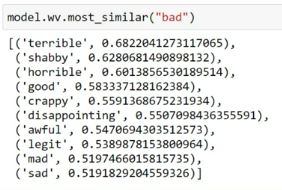

training process can be improve. by fine tuning , input more training data, bigger data set , etc...

In [39]:
model.wv.similarity(w1="cheap", w2="inexpensive")

0.50753665

In [47]:
model.wv.similarity(w1="cheap", w2="disappointing")

0.38966215

In [43]:
model.wv.similarity(w1="great", w2="great")

0.99999994

In [40]:
model.wv.similarity(w1="great", w2="good")

0.7788622

In [42]:
model.wv.similarity(w1="great", w2="awesome")

0.74732465

### **Further Reading**

You can read about gensim more at https://radimrehurek.com/gensim/models/word2vec.html

Explore other Datasets related to Amazon Reviews: http://jmcauley.ucsd.edu/data/amazon/

### **Exercise**

Train a word2vec model on the Sports & Outdoors Reviews Dataset Once you train a model on this, find the words most similar to 'awful' and find similarities between the following word tuples: ('good', 'great'), ('slow','steady')